# Model 4: Review Baseline Example
Here, we will use all of the encoded data and sentiment scores to create a new model using numerical features.

In [1]:
# ===============LICENSE_START=======================================================
# Apache-2.0
# ===================================================================================
# Copyright (C) 2019 AT&T Intellectual Property  All rights reserved.
# ===================================================================================
# This software file is distributed by AT&T
# under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# This file is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ===============LICENSE_END=========================================================

import pandas as pd  # data read
from sklearn import preprocessing  # data ETL
import os,sys  # file checks
import dill as pickle   # serialize functions and data as compressed binary 
import gzip  # compression 
import yaml   # configuration file
from matplotlib import pyplot as plt

import util_review
import util_train

# for interactive graphs
# %matplotlib notebook  

config_path = 'config.yaml'
if not os.path.isfile(config_path):
    print("Sorry, can't find the configuration file {}, aborting.".format(config_path))
    sys.exit(-1)
config = yaml.safe_load(open(config_path))

In [2]:
# read our larger datasets as binary files
with gzip.open(config["path"]["etl"], 'rb') as f:
    df = pickle.load(f)
# read our intermediate model data (in case we need to transform again)
with gzip.open(config["path"]["model_preproc"], 'rb') as f:
    etl = pickle.load(f)   # note that we use local variable 'etl' instead of 'models'
# read our features from the sentiment model
with gzip.open(config["path"]["sentiment"], 'rb') as f:
    df_sentiment = pickle.load(f)   # note that we use local variable 'df_sentiment'
    
print(df.keys())
print("Loaded Dimensionality: Training({}), RawTest({})".format(
    df["X_train"].shape, df["X_test"].shape ))

print(df_sentiment.keys())
print("Loaded Sentiment Dimensionality: Training({}), Test({})".format(
    df_sentiment["X_train"].shape, df_sentiment["X_test"].shape ))

dict_keys(['X_train', 'X_test', 'y_train', 'y_test', 'X_train_raw'])
Loaded Dimensionality: Training((20299, 1115)), RawTest((5075, 6))
dict_keys(['X_test', 'X_train', 'col_sentiment'])
Loaded Sentiment Dimensionality: Training((20299, 3)), Test((5075, 3))


# Preprocessing 
Preprocessing will run through required steps to generate extra columns and normalize (according to inputs) for the underlying predictors to train/evaluate a sample.

**NOTE** In this notebook (versus training our raw model), we will also augment the training and testing data to include sentiment features from our selected sentiment classifiers.

In [3]:
# save the FUNCTION and a data example for later use!
df["X_test_enc"] = df["X_test"].copy()  # start raw features
df["X_test_enc"] = etl["fn_preproc"](etl, df["X_test"])  # precess
df["X_train_enc"] = df["X_train"].copy()  # copy train data (already encoded)

models = {}
models["col_norm"] = df_sentiment["X_train"].columns  # what columns came from sentiment data?
df["X_test_enc"] = df["X_test_enc"].join(df_sentiment["X_test"]).fillna(0)
df["X_train_enc"] = df["X_train_enc"].join(df_sentiment["X_train"]).fillna(0)


## Stats on New Features
We've now incorporated all of the new sentiment features.  Let's check the distribution and range of these new features before we throw them into our learning again.


New Columns: ['yelp_reviewText_000', 'care_reviewText_000', 'twitter_reviewText_000']


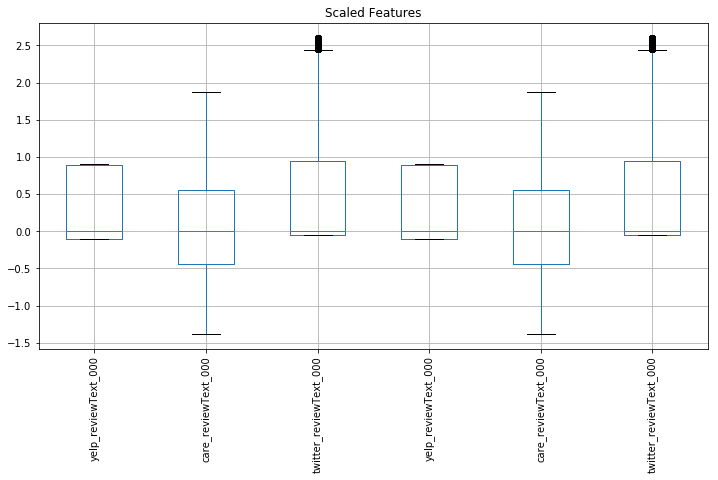

Index(['re_10', 're_34', 're_3m', 're_able', 're_actually', 're_address',
       're_adhesive', 're_amazon', 're_avery', 're_away',
       ...
       'cat_wooden colored pencils', 'cat_wrist rests',
       'cat_writing & correction supplies', 't_DOW', 't_month', 't_year',
       't_day', 'yelp_reviewText_000', 'care_reviewText_000',
       'twitter_reviewText_000'],
      dtype='object', length=1118)


In [4]:

# fit the scaler on training
print("New Columns: {}".format(list(models["col_norm"])))
# first, train new scalar
models, df["X_train_enc"][models["col_norm"]] = util_review.preproc_scaler(
    models, df["X_train_enc"][models["col_norm"]], df["X_train_enc"][models["col_norm"]].copy(), True)
# now evaluate on the test data for new sentiment columns
_, df["X_test_enc"][models["col_norm"]] = util_review.preproc_scaler(
    models, df["X_test_enc"][models["col_norm"]])
print(df["X_train_enc"].columns)


# Performance Evaluation
We repeat the training process completed in the baseline script but now with more features.

In [5]:
models = util_train.train_model(df["X_train_enc"], df["y_train"], config["training"]["scoring"], 
                                config["training"]["model_type"], config["training"]["cross_validate"], 
                                config["training"]["threads"])
    

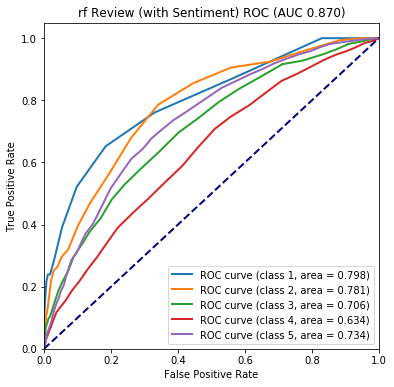

rf+Sentiment AUC: 0.870, trained time: 16.600s


In [6]:

# print performance!
auc_class, fig = util_review.draw_roc(df["X_test_enc"], df["y_test"], 
                                 classifier=models["best"], 
                                 title="{} Review (with Sentiment) ROC".format(config["training"]["model_type"]))
fig.savefig(config["path"]["figure_fused"])  # saves the current figure

print("{}+Sentiment AUC: {:0.3f}, trained time: {:0.3f}s".format(config["training"]["model_type"], 
                                                                 auc_class, models["time_train"]))


In [7]:
# finally, write out our intermediate data...
# and write out our intermediate model data (in case we need to transform again)
with gzip.open(config["path"]["model_fused"], 'wb') as f:
    pickle.dump(models, f)


# What Happened?
If we compare the original performance (specifically the ROC plots) to the one plotted above, we can see that the sentiment features -- even the small handfull of them -- has improved the shape of our function and overall performance.  Specifically, the ROC curve has been pulled up and to the left, at the intersection of lower false positives and higher true positives.  All classes except `class 4` (our worst individual performer) seem to show this effect.  The mean AUC itself has also improved but only marginally.

## Additional Shared Insights
Taking these findings as an example, this should motivate the reuse of other experts' models.  Remember, all that we did in this case was utilize someone else's hard work in sentiment clasification and join that to our prior data via early fusion.  

| *before* | *after* |
|:--------:|:-------:|
| ![raw features](data/model_classifier.png) | ![sentiment features](data/model_sentiment_fused.png) |